# Benchmark Matrix 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time
import adelie as ad 
import bench_matrix as bm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy

## Utility Functions

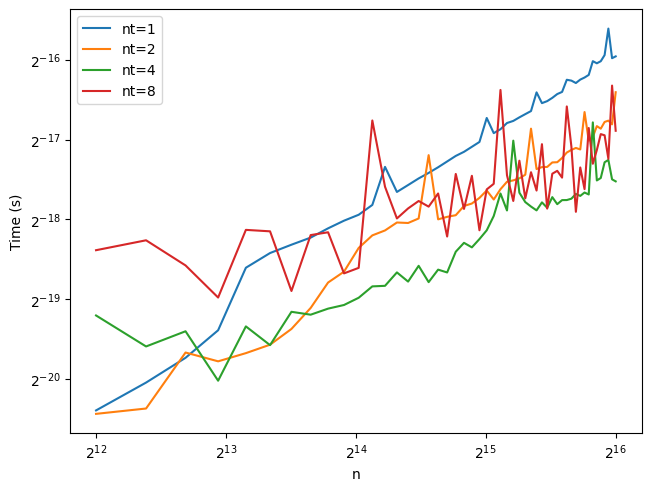

In [164]:
out = bm.bench_dv(
    method="dvaddi",
    n_list=np.linspace(1<<12, 1<<16).astype(int),
    n_sims=10000,
    min_bytes=int(1<<0),
)

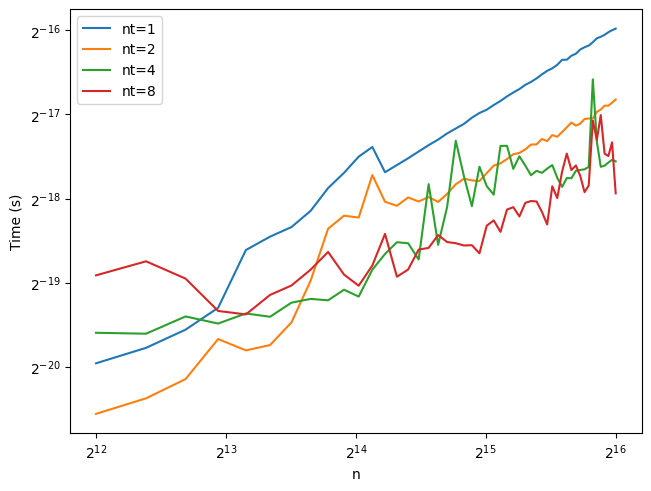

In [165]:
out = bm.bench_dv(
    method="dvsubi",
    n_list=np.linspace(1<<12, 1<<16).astype(int),
    n_sims=10000,
    min_bytes=int(1<<0),
)

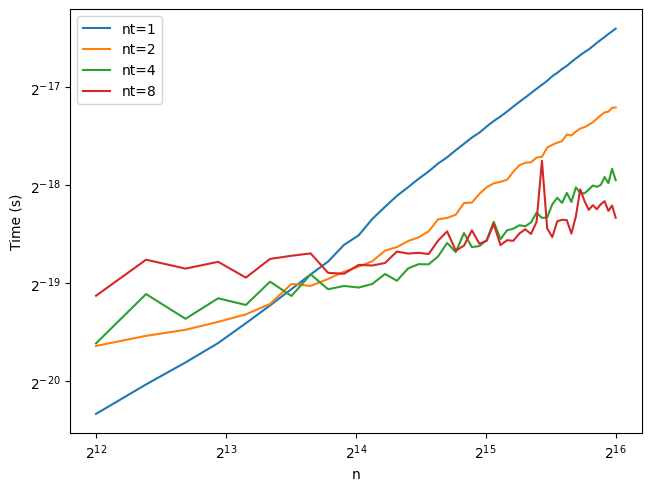

In [221]:
out = bm.bench_dv(
    method="dvveq",
    n_list=np.linspace(1<<12, 1<<16).astype(int),
    n_sims=10000,
    min_bytes=int(1<<0),
)

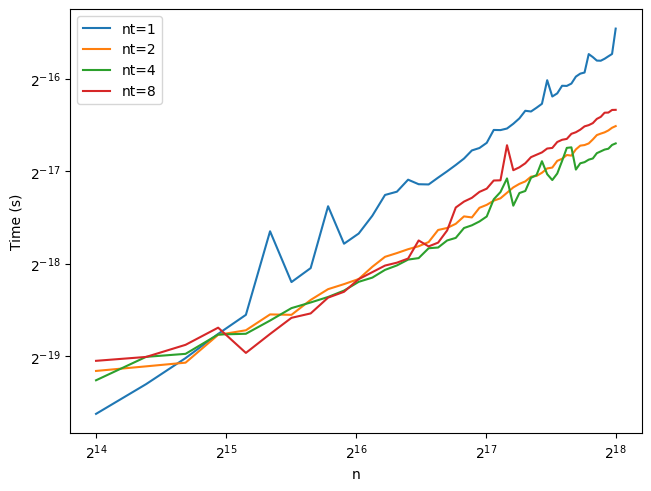

In [222]:
out = bm.bench_dv(
    method="dvzero",
    n_list=np.linspace(1<<14, 1<<18).astype(int),
    n_sims=10000,
    min_bytes=int(1<<0),
)

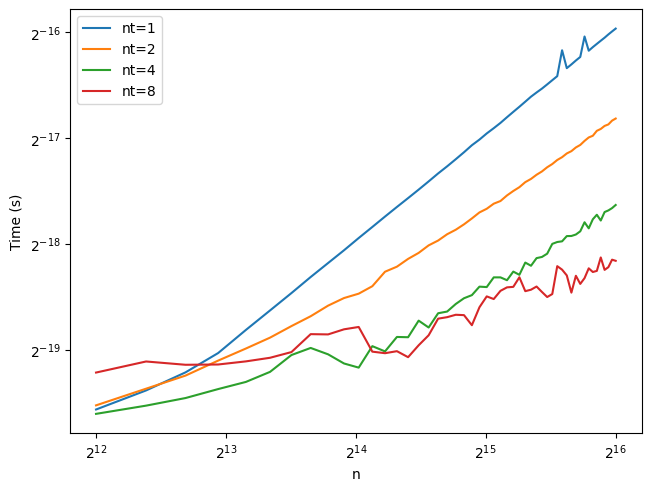

In [223]:
out = bm.bench_dv(
    method="ddot",
    n_list=np.linspace(1<<12, 1<<16).astype(int),
    n_sims=10000,
    min_bytes=int(1<<0),
)

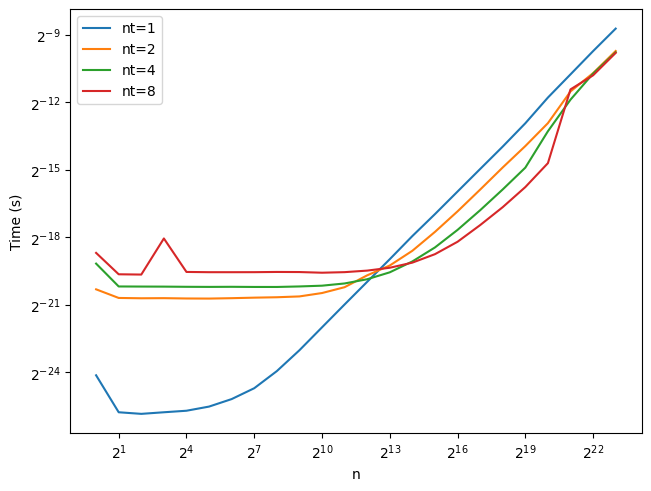

In [13]:
out = bm.bench_dv(
    method="ddot_opt",
    n_sims=100,
    min_bytes=int(1<<0),
)

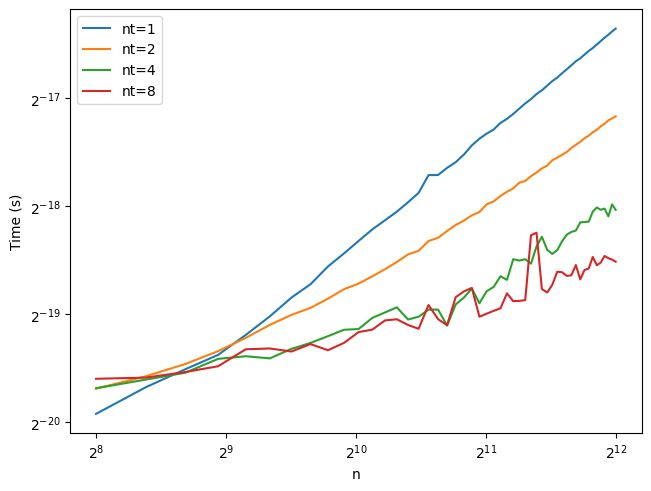

In [224]:
out = bm.bench_dm(
    method="dmmeq",
    m=4,
    n_list=np.linspace(1<<8, 1<<12).astype(int),
    n_sims=10000,
    min_bytes=int(1<<0),
)

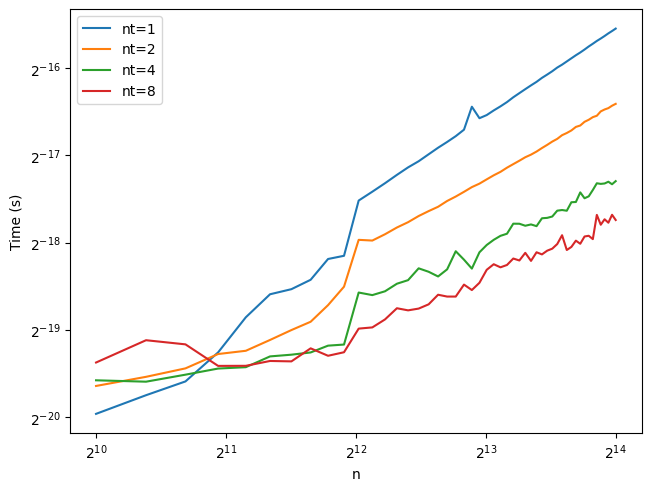

In [225]:
out = bm.bench_dm(
    method="dgemv_eq",
    m=8,
    n_list=np.linspace(1<<10, 1<<14).astype(int),
    n_sims=10000,
    min_bytes=int(1<<0),
)

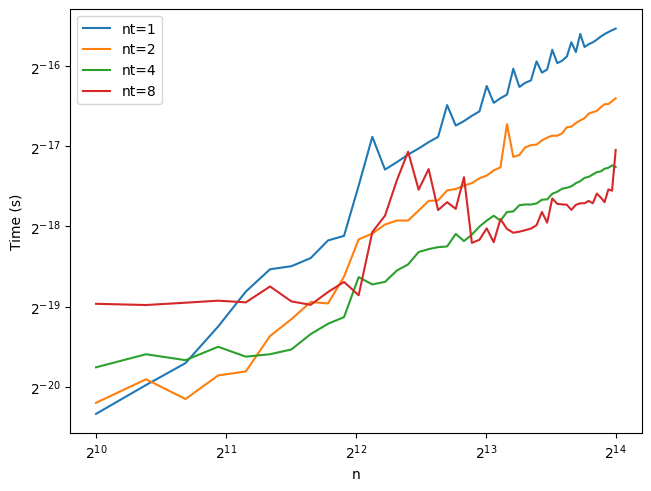

In [177]:
out = bm.bench_dm(
    method="dgemv_add",
    m=8,
    n_list=np.linspace(1<<10, 1<<14).astype(int),
    n_sims=10000,
    min_bytes=int(1<<0),
)

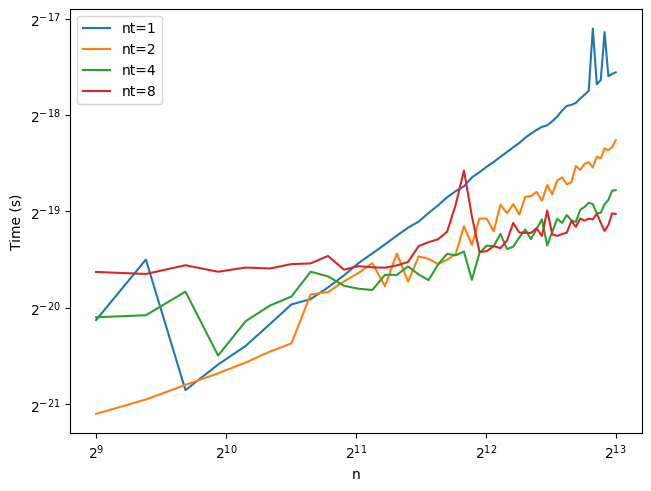

In [228]:
out = bm.bench_sp(
    method="spddot",
    n_list=np.linspace(1<<9, 1<<13).astype(int),
    n_sims=10000,
    min_bytes=int(1<<0),
)

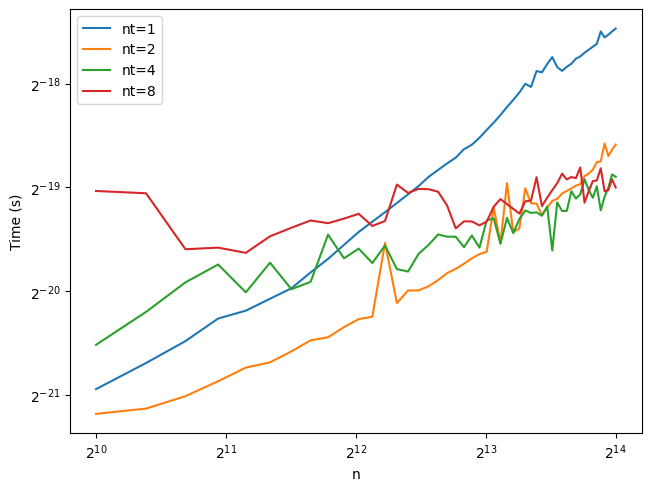

In [230]:
out = bm.bench_sp(
    method="spaxi",
    n_list=np.linspace(1<<10, 1<<14).astype(int),
    n_sims=10000,
    min_bytes=int(1<<0),
)

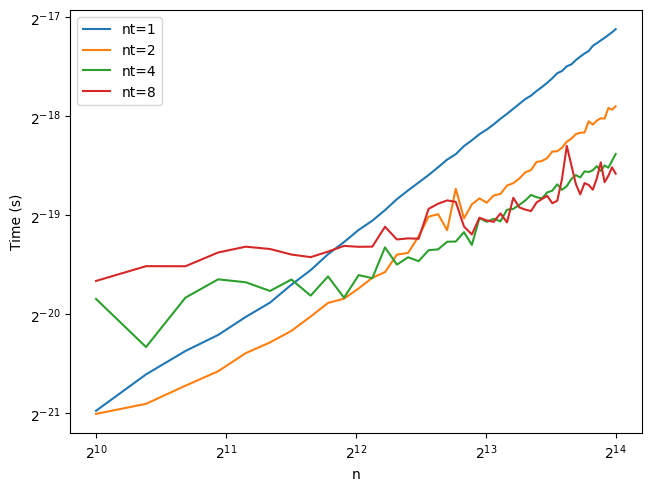

In [231]:
out = bm.bench_io(
    method="snp_unphased_dot",
    n_list=np.linspace(1<<10, 1<<14).astype(int),
    n_sims=10000,
    min_bytes=int(1<<0),
)

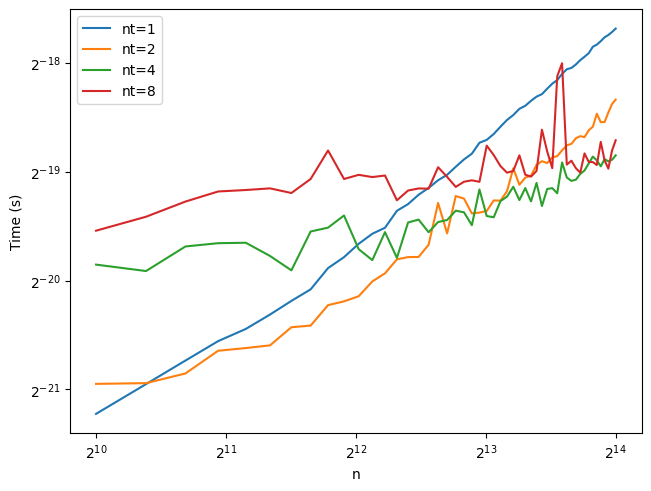

In [235]:
out = bm.bench_io(
    method="snp_unphased_axi",
    n_list=np.linspace(1<<10, 1<<14).astype(int),
    n_sims=10000,
    min_bytes=int(1<<0),
)

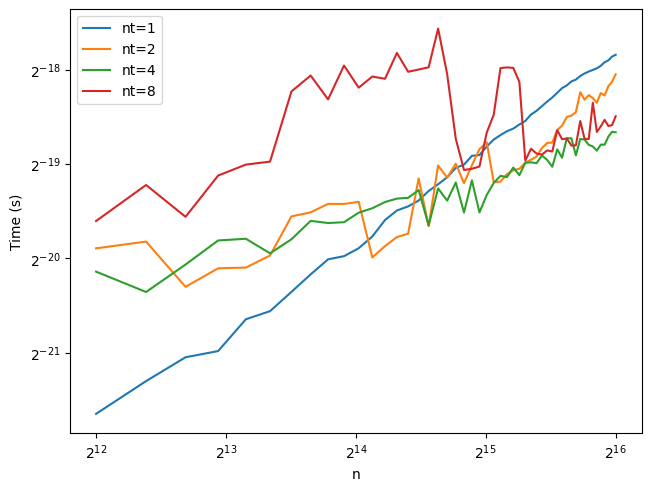

In [237]:
out = bm.bench_io(
    method="snp_phased_ancestry_dot",
    n_list=np.linspace(1<<12, 1<<16).astype(int),
    n_sims=10000,
    min_bytes=int(1<<0),
)

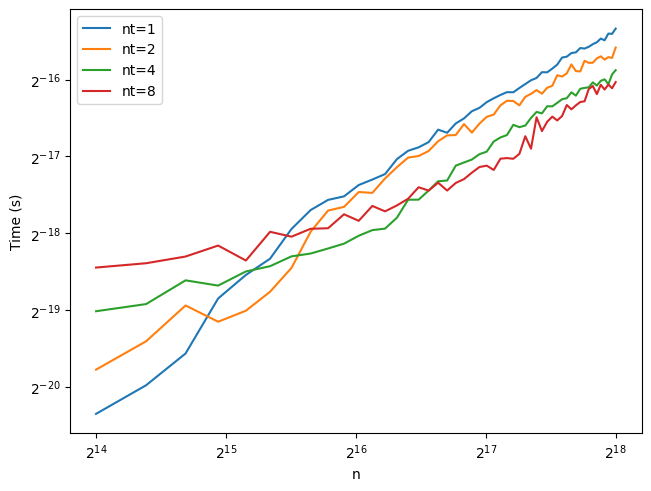

In [239]:
out = bm.bench_io(
    method="snp_phased_ancestry_axi",
    n_list=np.linspace(1<<14, 1<<18).astype(int),
    n_sims=10000,
    min_bytes=int(1<<0),
)

## MatrixNaive

## ad.matrix.dense

In [127]:
n = 100000
p = 100
q = 8
X = np.asfortranarray(np.random.normal(0, 1, (n, p)))

In [128]:
ad.configs.set_configs("min_bytes", None)

In [142]:
bm.bench_naive(ad.matrix.dense(X, method="naive", n_threads=1), q=q)

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.049114,0.045061,0.252008,0.185728,2.0051,1.449823,8.424997


In [154]:
bm.bench_naive(ad.matrix.dense(X, method="naive", n_threads=4), q=q)

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.05722,0.036001,0.128746,0.683069,1.012087,1.075029,10.319948


## ad.matrix.interaction

In [112]:
n = 10000
d = 100
dtype = np.float64
order = "F"
seed = 0#8

np.random.seed(seed)
X = np.random.normal(0, 1, (n, d))
X = np.array(X, dtype=dtype, order=order)
c_subset = np.random.choice(d, size=d//2, replace=False)
c_levels = 1 + np.random.choice(10, size=d//2, replace=True)
for j, level in zip(c_subset, c_levels):
    X[:, j] = np.random.choice(level, size=n, replace=True)
levels = np.zeros(d, dtype=int)
levels[c_subset] = c_levels
intr_map = {}
for j in range(min(10, d)):
    if np.random.binomial(1, 0.1, 1):
        intr_map[j] = None
    else:
        intr_map[j] = np.random.choice(d, size=d//2, replace=False)
cX = ad.matrix.interaction(X, intr_map, levels=levels, n_threads=1)
levels[cX.pairs[0,0]], levels[cX.pairs[0,1]] 

(2, 7)

In [113]:
ad.configs.set_configs("min_bytes", None)
l0 = levels[cX.pairs[0,0]]
l1 = levels[cX.pairs[0,1]] 
l0_cont = l0 <= 0
l1_cont = l1 <= 0
l0 = 2 if l0_cont else l0
l1 = 2 if l1_cont else l1
q = l0 * l1 - l0_cont * l1_cont
q

14

In [109]:
bm.bench_naive(ad.matrix.interaction(X, intr_map, levels=levels, n_threads=1), q=q)

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.020027,0.025034,0.020981,0.014067,11.401415,0.026941,283.282995


In [110]:
bm.bench_naive(ad.matrix.interaction(X, intr_map, levels=levels, n_threads=8), q=q)

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.020981,0.010014,0.021935,0.01502,2.650261,0.025988,61.610937


## ad.matrix.kronecker_eye

In [8]:
n = 1024
p = 100
K = 512
X = np.asfortranarray(np.random.normal(0, 1, (n, p)))

In [9]:
ad.configs.set_configs("min_bytes", None)

In [17]:
bm.bench_naive(ad.matrix.kronecker_eye(X, K=K, n_threads=1), q=K)

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.035048,0.545979,0.540733,3.405094,3.80373,1.57094,301.413298


In [16]:
bm.bench_naive(ad.matrix.kronecker_eye(X, K=K, n_threads=2), q=K)

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.024796,0.541925,0.376225,3.597975,2.022266,1.497746,261.30724


In [87]:
bm.bench_naive(ad.matrix.kronecker_eye(ad.matrix.dense(X, n_threads=1), K=K, n_threads=1), q=K)

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.0422,0.586987,1.652002,3.663301,9.325743,0.865936,304.234028


In [88]:
bm.bench_naive(ad.matrix.kronecker_eye(ad.matrix.dense(X, n_threads=4), K=K, n_threads=4), q=K)

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.036001,0.546932,1.834869,3.809929,9.228706,0.869989,267.845869


## ad.matrix.one_hot

In [261]:
n = 100000
d = 100
dtype = np.float64
order = "F"
seed = 3

np.random.seed(seed)
X = np.random.normal(0, 1, (n, d))
X = np.array(X, dtype=dtype, order=order)
c_subset = np.random.choice(d, size=d//2, replace=False)
c_levels = 1 + np.random.choice(10, size=d//2, replace=True)
for j, level in zip(c_subset, c_levels):
    X[:, j] = np.random.choice(level, size=n, replace=True)
levels = np.zeros(d, dtype=int)
levels[c_subset] = c_levels
cX = ad.matrix.one_hot(X, levels)
levels[0]

10

In [262]:
ad.configs.set_configs("min_bytes", None)
q = max(levels[0], 1)

In [265]:
bm.bench_naive(ad.matrix.one_hot(X, levels=levels, n_threads=1), q=q)

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.156879,0.044823,0.190973,0.090122,13.246059,0.172853,86.375952


In [266]:
bm.bench_naive(ad.matrix.one_hot(X, levels=levels, n_threads=4), q=q)

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.163078,0.051022,0.190973,0.090837,3.938675,0.19002,30.008078


## ad.matrix.snp_unphased

In [91]:
n = 20000
p = 100
seed = 0
data = ad.data.snp_unphased(n, p, seed=seed)
filename = "/tmp/bench_snp_unphased.snpdat"
handler = ad.io.snp_unphased(filename)
_ = handler.write(data["X"])
_ = handler.read()

In [92]:
ad.configs.set_configs("min_bytes", 1 << 17)

In [106]:
bm.bench_naive(ad.matrix.snp_unphased(filename, n_threads=1))

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.025749,0.016212,0.119925,0.095129,1.372814,0.566006,8.950949


In [122]:
bm.bench_naive(ad.matrix.snp_unphased(filename, n_threads=4))

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.044107,0.045061,0.038147,0.030041,0.246763,4.061222,6.582737


In [13]:
os.remove(filename)

## ad.matrix.snp_phased_ancestry

In [85]:
n = 100000
s = 100
A = 8
seed = 0
data = ad.data.snp_phased_ancestry(n, s, A, seed=seed)
filename = "/tmp/bench_snp_phased_ancestry.snpdat"
handler = ad.io.snp_phased_ancestry(filename)
_ = handler.write(data["X"], data["ancestries"], A)
_ = handler.read()

In [112]:
bm.bench_naive(ad.matrix.snp_phased_ancestry(filename, n_threads=1))

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.014782,0.010967,0.069141,0.061274,6.093025,0.313282,56.190968


In [118]:
bm.bench_naive(ad.matrix.snp_phased_ancestry(filename, n_threads=4))

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.045776,0.01502,0.112772,0.075102,1.880169,0.32115,17.745972


In [ ]:
os.remove(filename)

## ad.matrix.sparse

In [114]:
n = 100000
p = 100
seed = 0

np.random.seed(seed)
X = np.random.normal(0, 1, (n, p)).astype(dtype)
X.flat[np.random.binomial(1, 0.5, X.size)] = 0
X_sp = {
    "C": scipy.sparse.csr_matrix,
    "F": scipy.sparse.csc_matrix,
}[order](X)

In [115]:
ad.configs.set_configs("min_bytes", None)

In [116]:
bm.bench_naive(ad.matrix.sparse(X_sp, n_threads=1))

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.19908,0.112057,1.31321,0.703812,15.33103,5.028725,51.545858


In [117]:
bm.bench_naive(ad.matrix.sparse(X_sp, n_threads=4))

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.141144,0.142097,0.669956,0.493765,4.496813,2.510071,18.731833


## ad.matrix.standardize

In [30]:
n = 130000
p = 100
dtype = np.float64
seed = 0

np.random.seed(seed)
X = np.asfortranarray(np.random.normal(0, 1, (n, p)).astype(dtype))

In [31]:
ad.configs.set_configs("min_bytes", None)

In [32]:
dX = ad.matrix.dense(X, n_threads=1) 
bm.bench_naive(ad.matrix.standardize(dX, n_threads=1))

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.100851,0.080109,0.307083,0.253916,2.556086,2.122879,8.808851


In [33]:
dX = ad.matrix.dense(X, n_threads=4) 
bm.bench_naive(ad.matrix.standardize(dX, n_threads=4))

,cmul,ctmul,bmul,btmul,mul,cov,sp_btmul
0,0.125885,0.087023,0.241041,0.216007,1.369953,1.69301,11.689901
